In [3]:
!pip install pyathena

  Using cached pyathena-3.0.10-py3-none-any.whl.metadata (72 kB)
  Using cached urllib3-2.0.7-py3-none-any.whl.metadata (6.6 kB)
Using cached pyathena-3.0.10-py3-none-any.whl (73 kB)
Using cached urllib3-2.0.7-py3-none-any.whl (124 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
###THE PURPOSE OF THIS NOTEBOOK IS TO COMPARE THE PERFORMANCE OF THE SIMPLE SARIMA MODEL WITH THE PROJECTIONS MADE BY VIAMERICAS FOR MEXICO.
##SEE EXCEL FILE BOOK7 (VIEW EXCEL FILE "BOOK7" SENT BY BORIS MARINOVIC)

In [5]:
from pyathena import connect
import pandas as pd

In [6]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_check'
##DAILY CHECK IS THE DATABASE VALIDATED WITH THE CLIENT, IT DOES NOT COUNT CANCELLATIONS OR VIRTUAL AGENCIES##

In [79]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

In [80]:
df2.shape

(103726, 4)

In [81]:
df2.head()

,payer,country,date,amount
0,BANCO AGRICOLA,EL SALVADOR,2023-03-13,426342.70
1,ARGENPER,CHILE,2023-07-07,875.38
2,BANCOPPEL (APPRIZA),MEXICO,2023-09-25,5051224.07
3,BANRURAL (RYT),GUATEMALA,2023-09-25,4010293.42
4,BANCO DE CREDITO DEL PERU - BCP (UT),PERU,2022-10-09,41946.00


In [10]:
##TO SPEED UP THE LOADING, WE ALREADY WORK WITH THE EXTRACTED CSV##

In [82]:
df1=pd.read_csv('rates_2021_2023.csv')

In [88]:
df1.symbol.unique()

array(['USDBRL', 'USDINR', 'USDGTQ', 'USDMXN', 'USDPHP'], dtype=object)

In [13]:
##WE FILTER DATA FOR MEXICO##

In [89]:
df_mex=df1.loc[df1.symbol=='USDMXN']

In [90]:
df_mex.head(3)

,feed_ask,feed_bid,feed_date,feed_id,feed_price,feed_remaining,feed_source,feed_time,symbol
3,17.0917,17.0917,2023-09-02 01:00:26,3842964,17.0917,45169,https://api.currencylayer.com/CHANGE,45169,USDMXN
8,17.0917,17.0917,2023-09-02 01:02:26,3842969,17.0917,45169,https://api.currencylayer.com/CHANGE,45169,USDMXN
13,17.0917,17.0917,2023-09-02 01:04:26,3842974,17.0917,45169,https://api.currencylayer.com/CHANGE,45169,USDMXN


In [91]:
df_mex.shape

(542216, 9)

In [17]:
##WE OBTAIN THE LAST VALUE OF THE EXCHANGE RATE OF EACH DAY ##

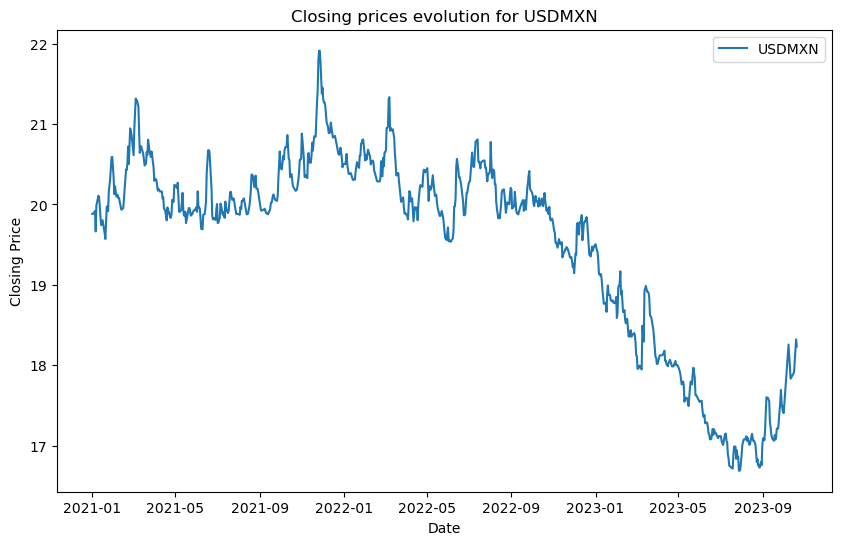

     symbol  feed_date  feed_price
0    USDMXN 2021-01-01     19.8822
1    USDMXN 2021-01-02     19.8822
2    USDMXN 2021-01-04     19.9046
3    USDMXN 2021-01-05     19.9196
4    USDMXN 2021-01-06     19.6648
..      ...        ...         ...
784  USDMXN 2023-10-08     18.2580
785  USDMXN 2023-10-11     17.8337
786  USDMXN 2023-10-16     17.9119
787  USDMXN 2023-10-19     18.3207
788  USDMXN 2023-10-20     18.2351

[789 rows x 3 columns]


In [92]:
import pandas as pd
import matplotlib.pyplot as plt

def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['feed_date'] = pd.to_datetime(data['feed_date'])

    # Filter by date range
    data_filtered = data[(data['feed_date'] >= start_date) & (data['feed_date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='feed_date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='feed_date', freq='D')])['feed_price'].last().reset_index()

    # Generate evolution plots for each SYMBOL
    for symbol in data_grouped['symbol'].unique():
        symbol_data = data_grouped[data_grouped['symbol'] == symbol]

        plt.figure(figsize=(10, 6))
        plt.plot(symbol_data['feed_date'], symbol_data['feed_price'], label=symbol)
        plt.title(f'Closing prices evolution for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    return data_grouped

# Using the function
# Suppose your DataFrame is named df
# Adjust the dates according to your needs
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_mex, start_date, end_date)
print(rates)

In [93]:
rates.head(3)

,symbol,feed_date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-04,19.9046


In [94]:
df2.amount.sum()

25110624454.414906

In [95]:
df2['date'] = pd.to_datetime(df2['date'])

In [22]:
##WE MERGE THE DATASETS TO HAVE TRADED AMOUNTS AND EXCHANGE RATES PER DAY##

In [96]:
rates = rates.rename(columns={'feed_date': 'date'})
rates['date'] = pd.to_datetime(rates['date'])

rates.head()

,symbol,date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-04,19.9046
3,USDMXN,2021-01-05,19.9196
4,USDMXN,2021-01-06,19.6648


In [24]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 

In [97]:
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates[nombre_columna] = rates['feed_price'].shift(i)

In [26]:
##FILTERING MEXICO##

In [98]:
df_montos_mex=df2.loc[df2.country=='MEXICO']

In [99]:
df_montos_mex.shape

(23567, 4)

In [100]:
df_montos_mex.amount.sum()

13655009099.176899

In [30]:
###WE MERGE THE RESULTING DATABASE WITH THE DATABASE OF RATES##

In [101]:
df_final=pd.merge(df_montos_mex, rates, on='date', how='left')

In [102]:
df_final.head(3)

,payer,country,date,amount,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,BANCOPPEL (APPRIZA),MEXICO,2023-09-25,5051224.07,USDMXN,17.4355,17.2138,17.2138,17.2142,17.1125,17.0777,17.1321,17.0619
1,WALDOS (APPRIZA),MEXICO,2022-05-26,4273.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BANORTE (UT),MEXICO,2022-04-15,323227.52,USDMXN,19.9403,19.9672,19.7899,20.0760,20.0370,20.1415,20.1658,19.8133


In [103]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE EXCHANGE RATE (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
df_pilot.shape

(1025, 13)

In [104]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
##SALES EVOLUTION GRAPH

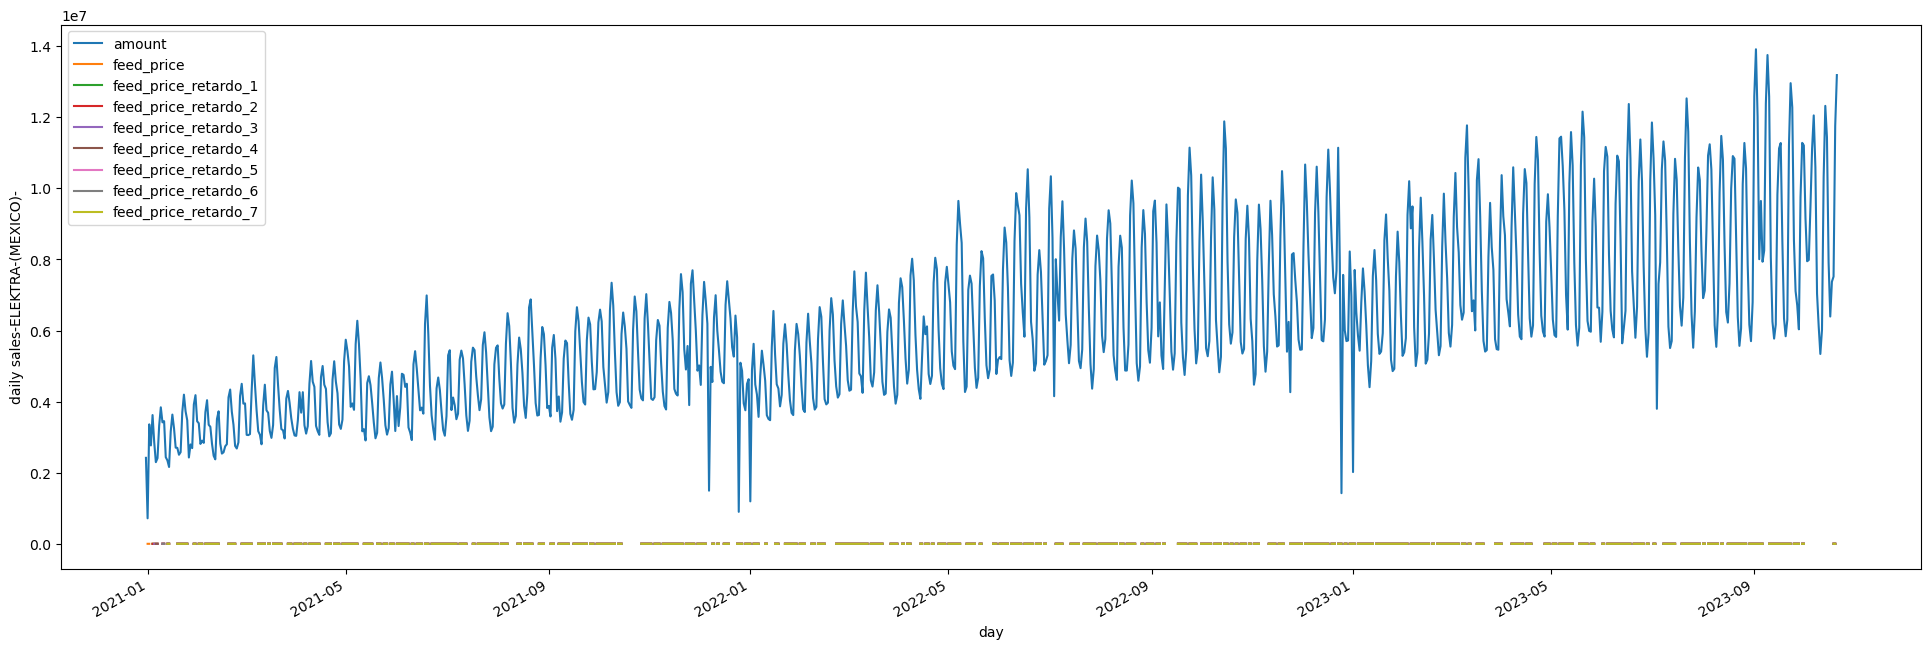

In [105]:
ax = df_pilot.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [106]:
##TIME SERIES FORMAT
data = df_pilot
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [107]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
data=data.loc[:,['amount']]

In [108]:
data = data.sort_values(by='date')

In [109]:
data.head(3)

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2020-12-31 to 2023-10-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  1025 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [42]:
##WE DECOMPOSE THE SERIES INTO TREND, SEASONALITY AND RESIDUALS

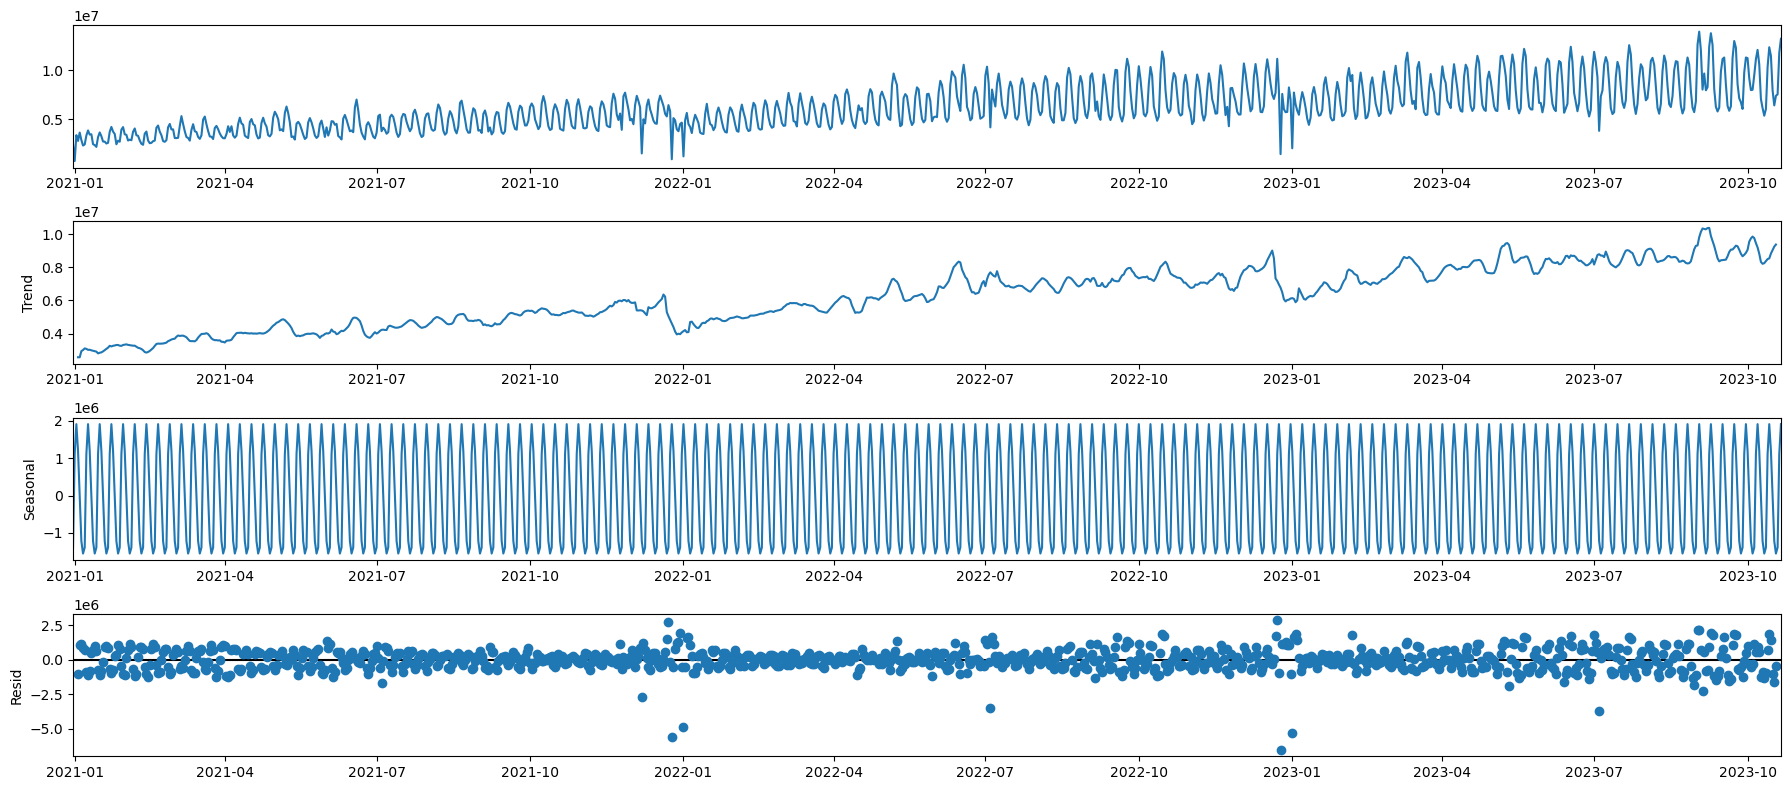

In [111]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='adittive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [44]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##
##The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
##If the pvalue is above a critical size, then we cannot reject that there is a unit root.
##In this case (ELEKTRA MÉXICO) we check that the series is non-stationary (0.58>0.05)

ADF Statistic: -1.391752
p-value: 0.586224
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


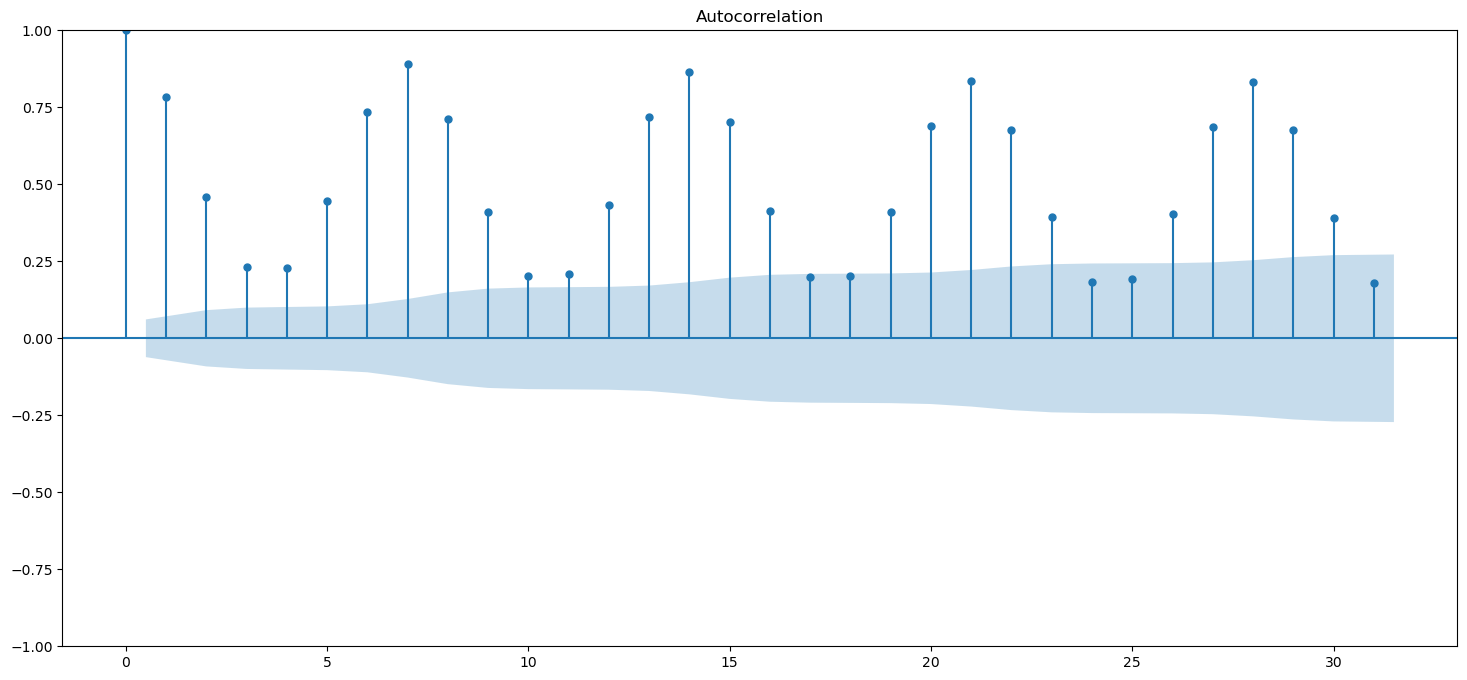

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

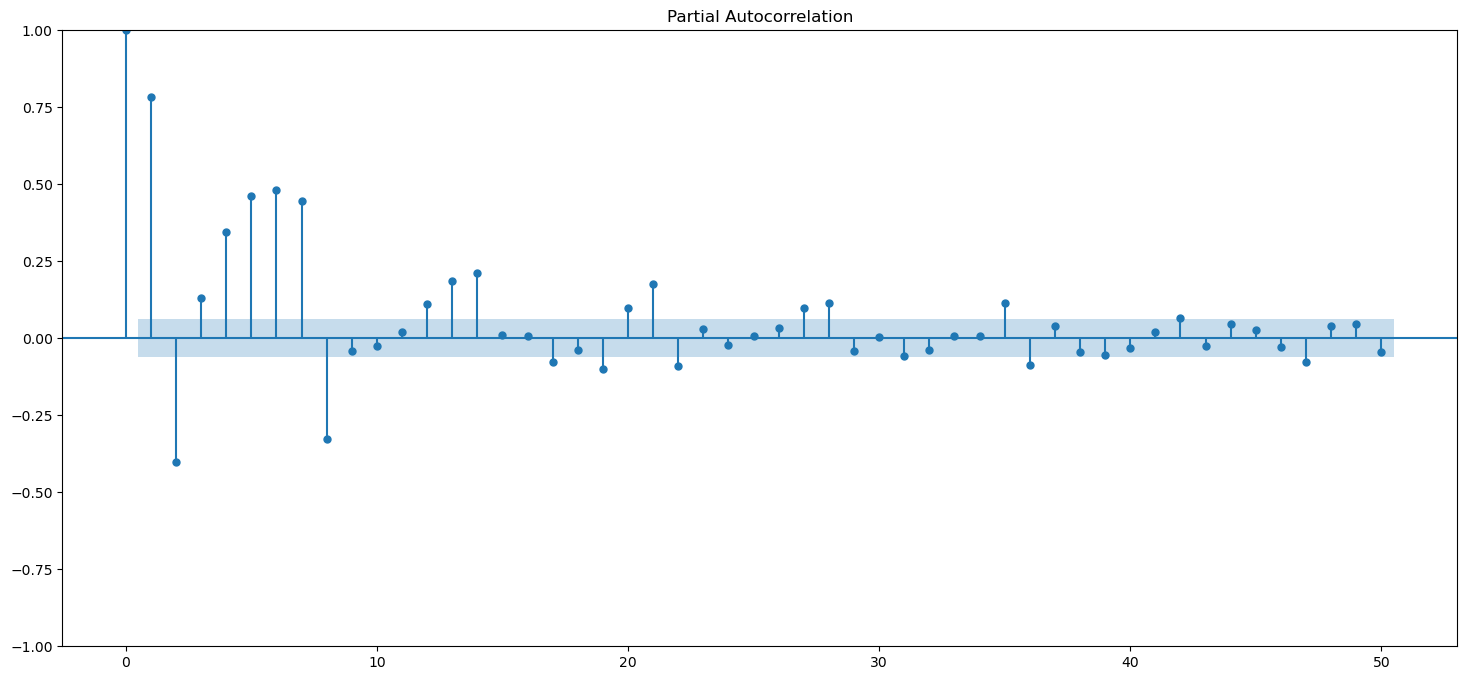

In [113]:
##PARTIAL AUTOCORRELATION##
##CORRELATION IN SALES AT TIME K AND K-NLAGS BACKWARDS
##EVEN LAG 14 SEEMS TO EXPLAIN TODAY'S AMOUNT (ELEKTRA CASE).
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=50)
plt.show()

In [47]:
##ARIMA PARAMETER SEARCH##

In [48]:
##SPLIT THE DATABASE INTO TRAIN AND TEST (WITH THE DATABASE SORTED TEMPORALLY)##

In [114]:
traindata = data[0:800] #data[0:800]
traindata.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [115]:
testdata = data[800:1025] #data[801:1025]
testdata.index

DatetimeIndex(['2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18',
               '2023-03-19', '2023-03-20',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=225, freq=None)

In [116]:
traindata.shape, testdata.shape

((800, 1), (225, 1))

In [117]:
##WE INSTALL A TIME SERIES LIBRARY THAT HELPS US TO SELECT THE BEST ARIMA MODEL AUTOMATICALLY##
!pip install pmdarima


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [53]:
##WE APPLY THE AUTOARIMA MODULE THAT SELECTS THE BEST MODEL FROM AMONG SEVERAL CANDIDATES
## BASED ON THE AUTOCORRELATION GRAPH, WE OBSERVE THAT VALUES OF UP TO 14 LAGS CAN AFFECT TODAY'S AMOUNT. WHICH IMPLIES P AND Q MAX=14 (ALWAYS TAKE CARE OF MODEL PARSIMONY).

In [118]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
# Adjusts the best arima model by looking for the one that minimizes the Akaike criterion (AIC)
stepwise_fit = auto_arima(traindata['amount'], start_p = 1, start_q = 1, 
                          max_p = 14, max_q = 14, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = 0, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
#p:The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.
#d:The degree of differencing.
#q:The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=23673.304, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24060.954, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=23774.062, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=23714.935, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24061.270, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=23856.346, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=23645.152, Time=0.59 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=23775.256, Time=0.48 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=23644.235, Time=1.74 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=23726.563, Time=1.02 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=23642.408, Time=2.43 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=23642.666, Time=1.73 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=23692.049, Time=2.50 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=23642.579, Time=1.92 sec
 ARIMA(2,0,1)(2,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11810.856
Date:                                Fri, 29 Dec 2023   AIC                          23641.711
Time:                                        14:46:50   BIC                          23688.469
Sample:                                    12-31-2020   HQIC                         23659.681
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.33e+04   9579.037      2.433      0.015    4529.511    4.21e+04
ar.L1          0.5313      0.021     24.824      0.000       0.489       0.573
ar.L2         -0.0319      0.038     -0.835      0.404      -0.107       0.043
ar.L3          0.0272      0.067      0.405      0.685      -0.104       0.159
ar.L4          0.0661      0.066      1.000      0.317      -0.063       0.196
ar.S.L7       -0.6055      0.199     -3.050      0.002      -0.995      -0.216
ar.S.L14       0.2330      0.096      2.434      0.015       0.045       0.421
ma.S.L7        0.0077      0.193      0.040      0.968      -0.370       0.386
ma.S.L14      -0.8119      0.185     -4.396      0.000      -1.174      -0.450
sigma2      6.647e+11      0.001   6.02e+14      0.000    6.65e+11    6.65e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19315.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+29. Standard errors may be unstable.
"""

In [120]:
##WE ASSIGN A TIME INDEX 
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [121]:
##WE ESTIMATE THE BEST MODEL SUGGESTED BY AUTO_ARIMA WITH THE SARIMAX MODULE (P=4,I=0,Q=0) (p=2,i=1,q=2,7-seven to indicate weekly seasonality-)
## FURTHERMORE, ADDITIONAL ESTIMATION CONTROLS ARE PRESENTED.
mod = sm.tsa.statespace.SARIMAX(traindata['amount'],  
                order = (4, 0, 0),  
                seasonal_order =(2, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47863D+01    |proj g|=  5.31490D-02


 This problem is unconstrained.



At iterate    5    f=  1.47717D+01    |proj g|=  2.06585D-03

At iterate   10    f=  1.47717D+01    |proj g|=  1.55336D-03

At iterate   15    f=  1.47712D+01    |proj g|=  7.01247D-03

At iterate   20    f=  1.47709D+01    |proj g|=  2.05044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     29      1     0     0   2.402D-05   1.477D+01
  F =   14.770905389976040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

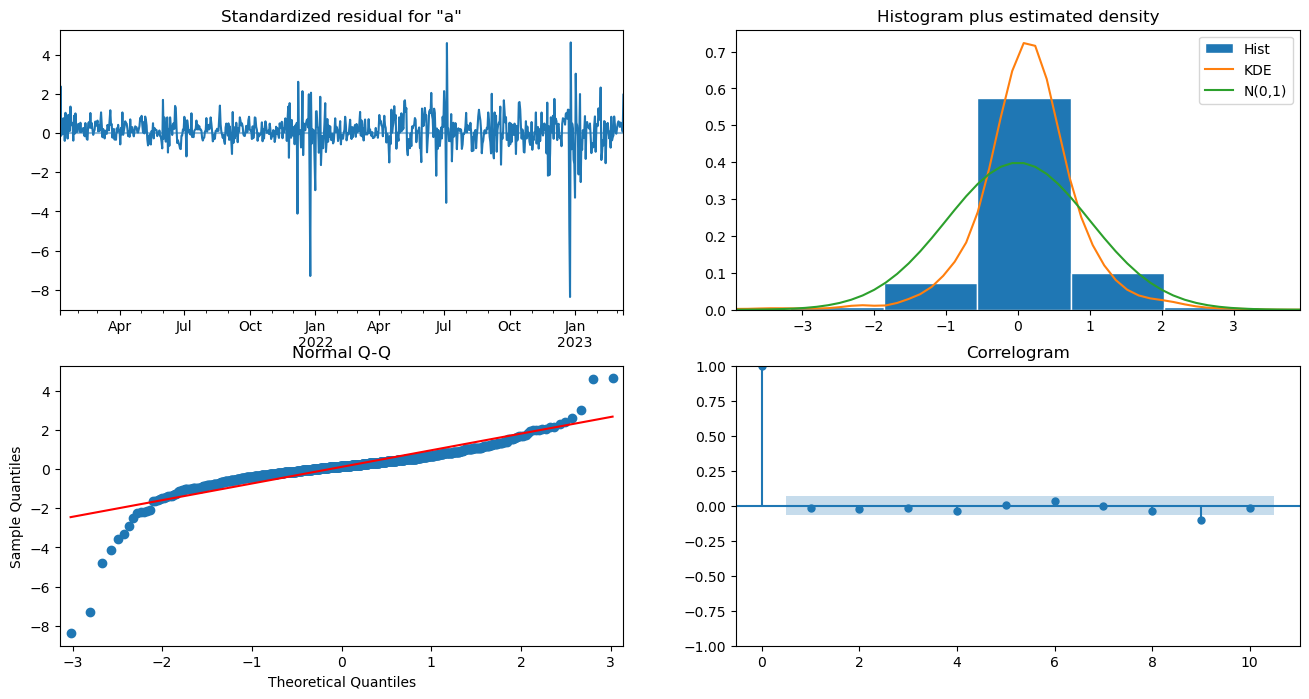

In [122]:
###NOTE THAT THERE ARE SOME DAYS WITH STRONG DEVIATIONS (DEC. 25, JAN. 1)
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [123]:
##WE NOW GENERATE THE FORECAST WITH THE ESTIMATED MODEL WITH THE TEST DATASET
pred = results.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False)
pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result             y
2023-03-12  7.100951e+06  1.073576e+07  8.918357e+06  9.990582e+06
2023-03-13  6.246968e+06  9.980507e+06  8.113738e+06  7.865035e+06
2023-03-14  4.672313e+06  8.444561e+06  6.558437e+06  6.543219e+06
2023-03-15  4.081997e+06  7.899706e+06  5.990851e+06  6.847888e+06
2023-03-16  4.249192e+06  8.096039e+06  6.172616e+06  6.002096e+06
2023-03-17  7.632976e+06  1.149380e+07  9.563389e+06  1.023570e+07
2023-03-18  8.133404e+06  1.229423e+07  1.021382e+07  1.082097e+07
2023-03-19  6.396106e+06  1.065208e+07  8.524091e+06  9.213543e+06
2023-03-20  5.553807e+06  9.838331e+06  7.696069e+06  7.104772e+06
2023-03-21  4.045298e+06  8.342450e+06  6.193874e+06  5.707731e+06
2023-03-22  3.625249e+06  7.934425e+06  5.779837e+06  5.407997e+06
2023-03-23  3.896483e+06  8.213189e+06  6.054836e+06  5.449343e+06
2023-03-24  7.051404e+06  1.137190e+07  9.211654e+06  8.071606e+06
2023-03-25  7.698854e+06  1.209605e+07  9.897452e+

In [124]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)

mae: 466039.3773934761
rmse: 564863.8102899819
mape: 0.06250582713403734


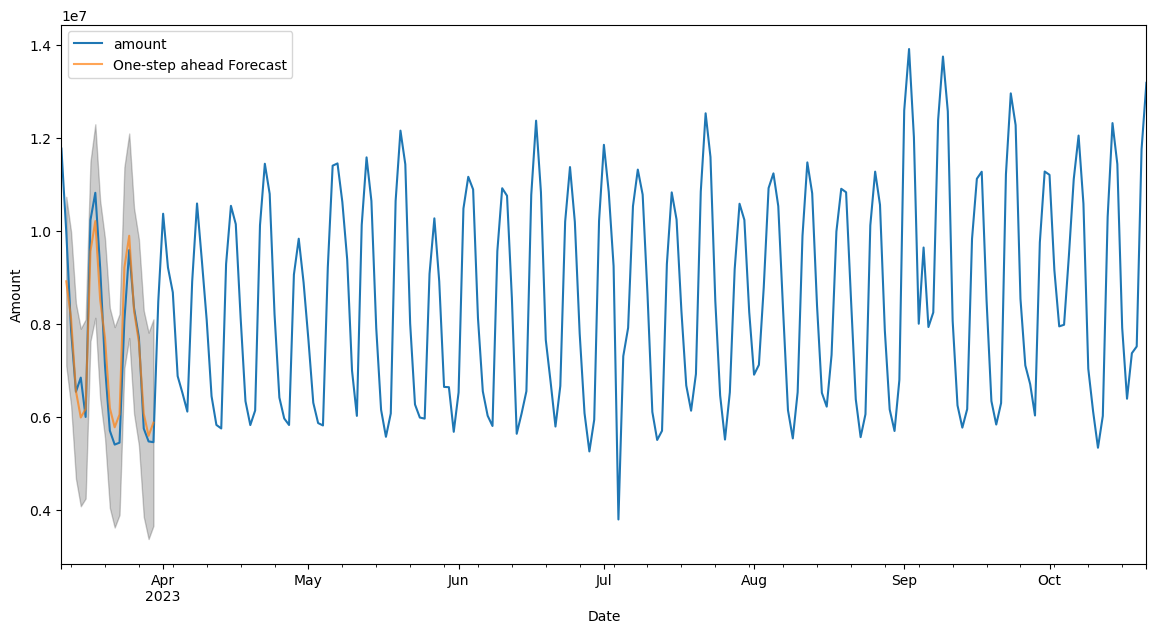

In [125]:
###GENERATE THE CONFIDENCE BANDS OF THE ESTIMATES (LOWER AND UPPER LIMIT) AND PLOT THE PREDICTED VALUE VS. THE ACTUAL VALUE

pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
###WE MAKE THE SAME ANALYSIS BUT FOR ALL MEXICO##

In [126]:
df_pilot2=df_final.loc[df_final.country=='MEXICO']
df_pilot2.shape

(23567, 13)

In [127]:
df_pilot2=df_pilot2.loc[:,['country', 'date', 'amount']]

In [128]:
df_pilot2['date'] = pd.to_datetime(df_pilot2['date'])
df_grouped = df_pilot2.groupby('date')['amount'].sum().reset_index()

In [129]:
df_grouped.head()

,date,amount
0,2020-12-31,5293582.62
1,2021-01-01,1675339.21
2,2021-01-02,7360935.77
3,2021-01-03,6358729.19
4,2021-01-04,8499604.51


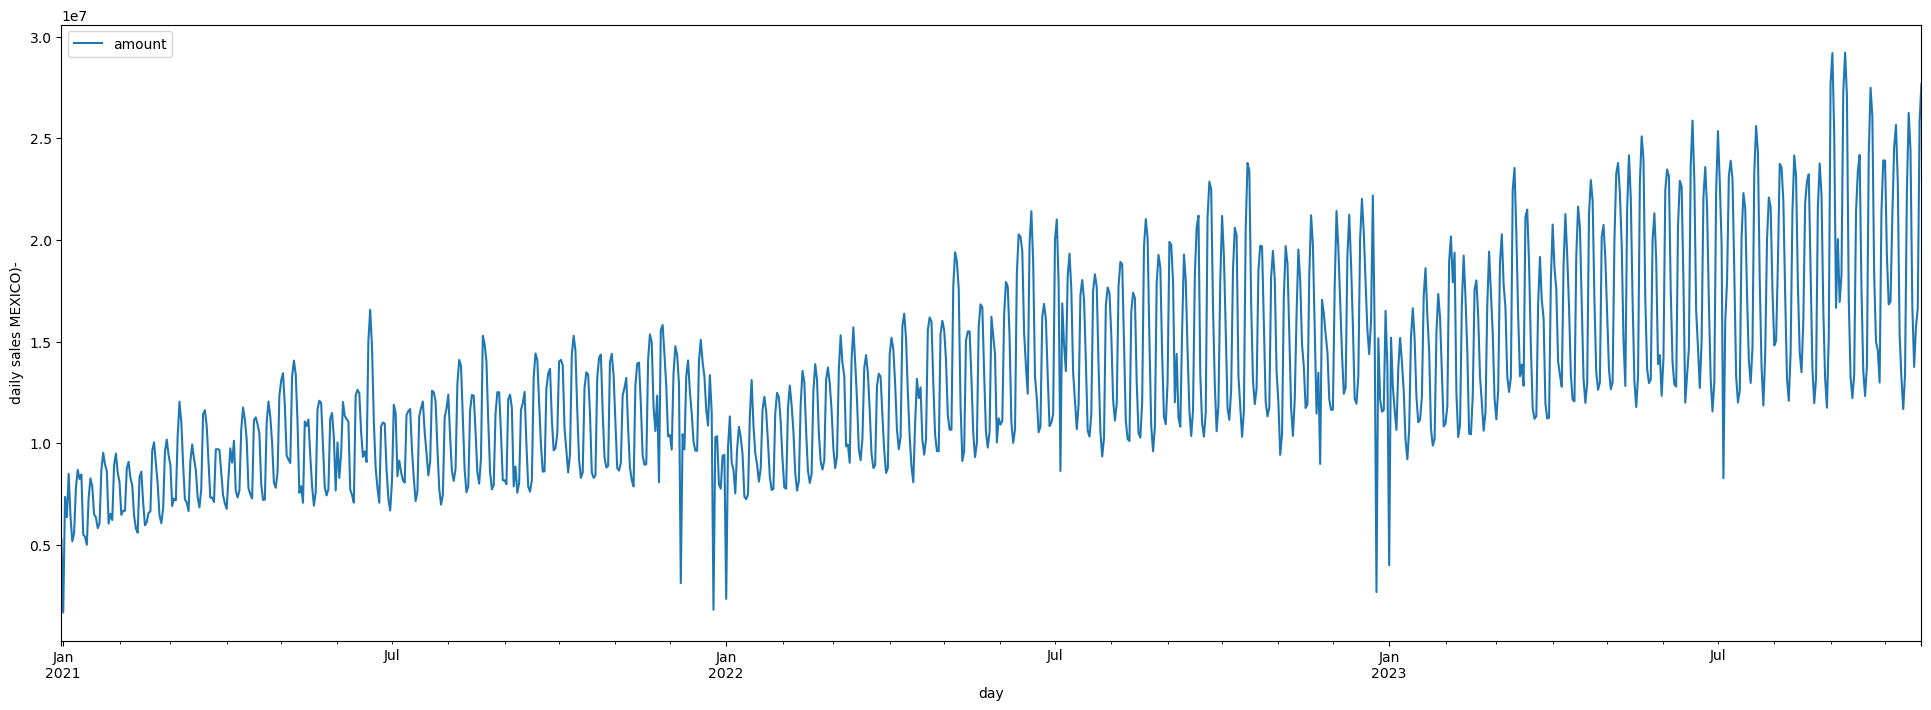

In [130]:
ax = df_grouped.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [131]:
##TIME SERIES FORMAT
data = df_grouped
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [132]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
data=data.loc[:,['amount']]

In [133]:
data = data.sort_values(by='date')

In [134]:
data.head()

,amount
date,
2020-12-31,5293582.62
2021-01-01,1675339.21
2021-01-02,7360935.77
2021-01-03,6358729.19
2021-01-04,8499604.51


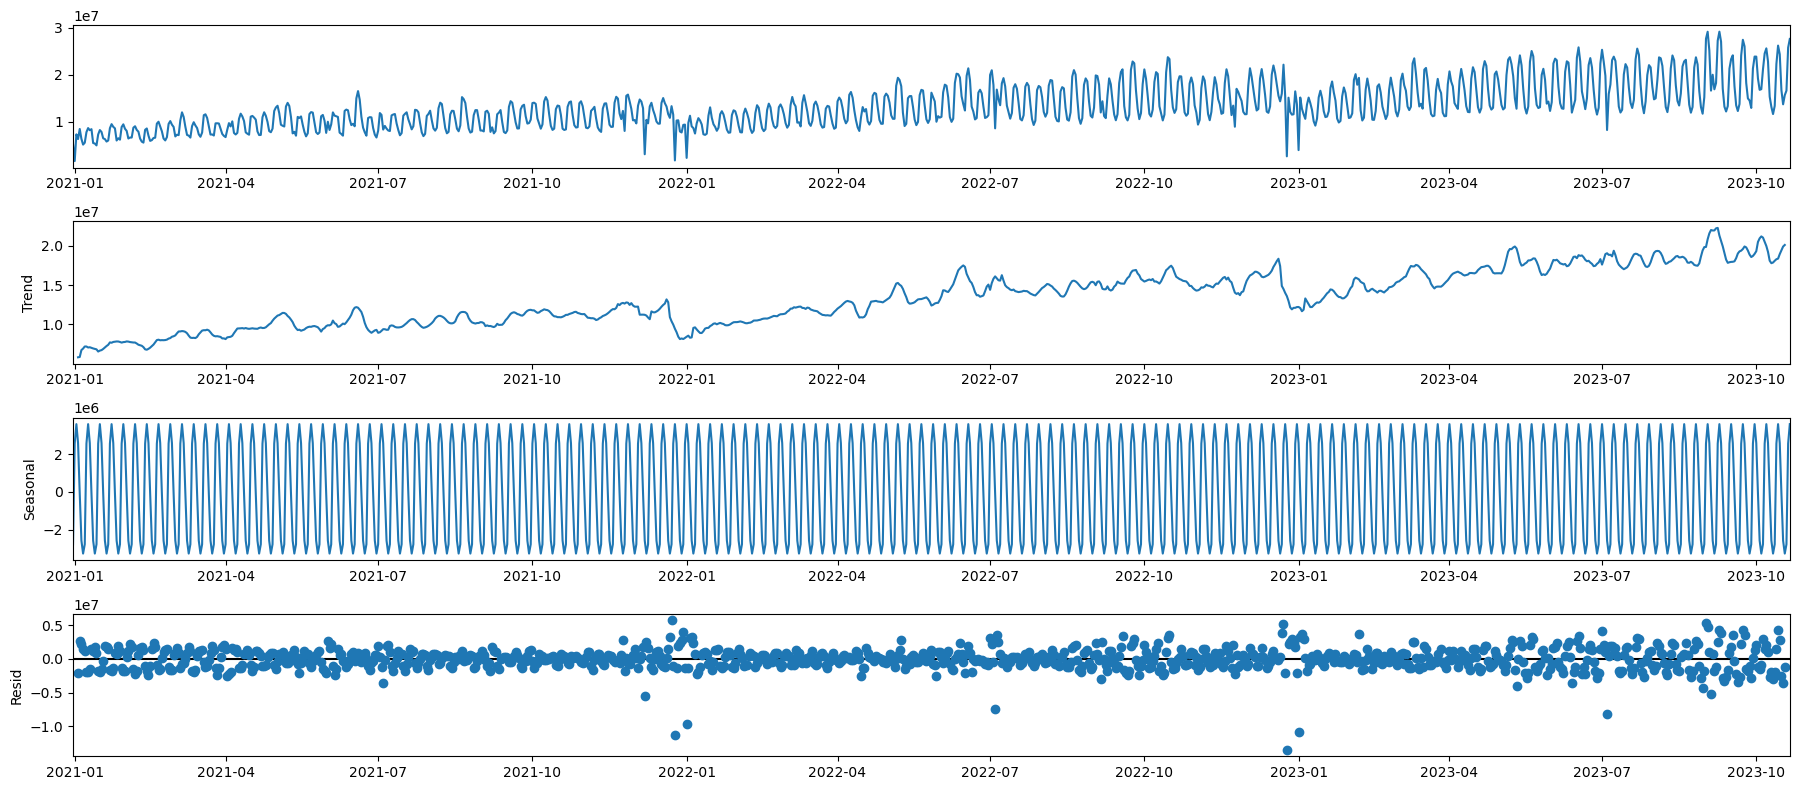

In [135]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

ADF Statistic: -1.352932
p-value: 0.604622
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


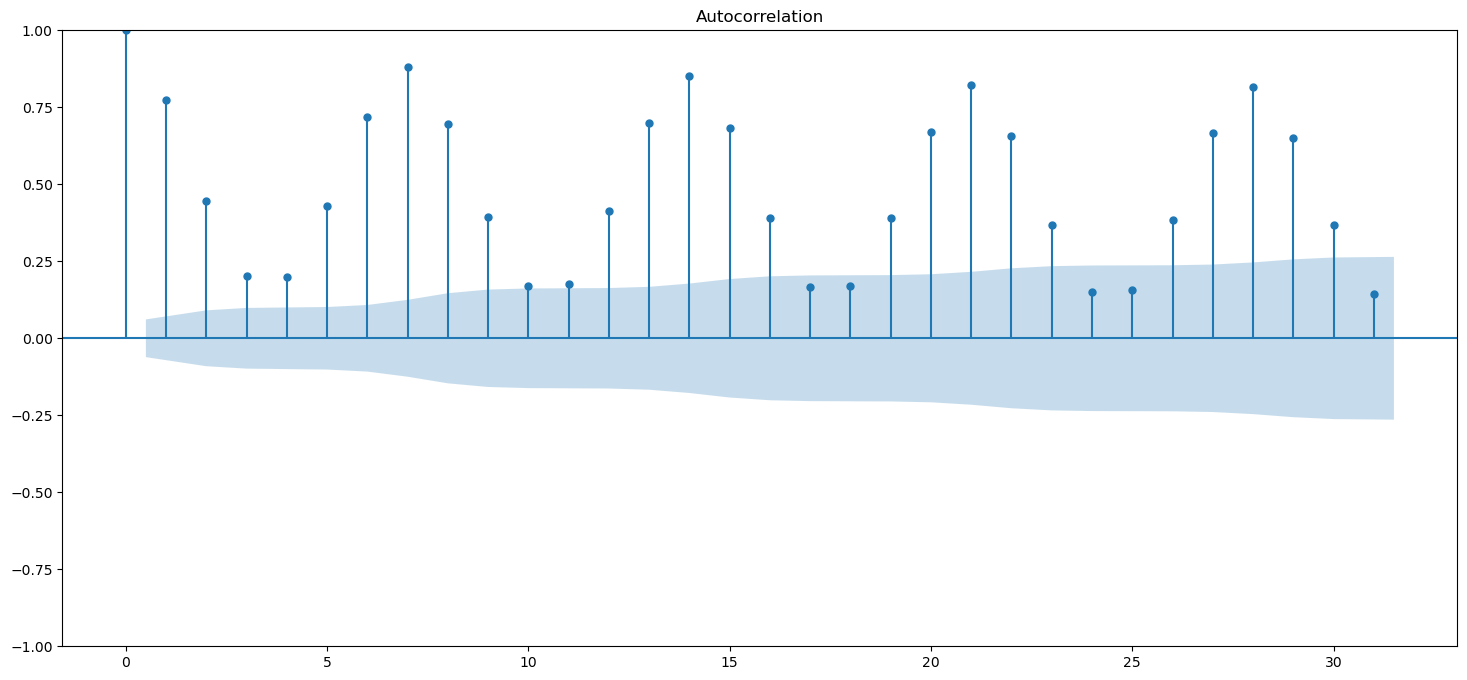

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

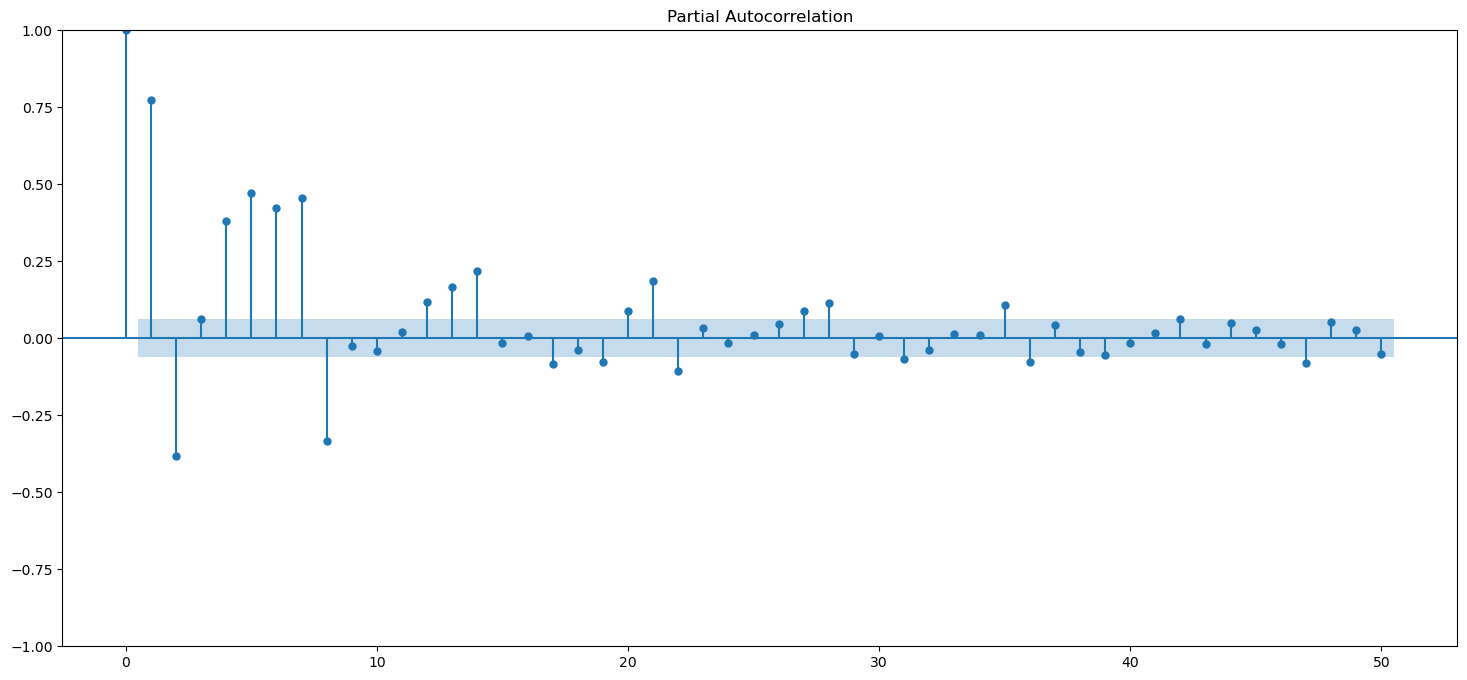

In [137]:
##PARTIAL AUTOCORRELATION##
##CORRELATION IN SALES AT TIME K AND K-NLAGS BACKWARDS
##EVEN LAG 14 SEEMS TO EXPLAIN TODAY'S AMOUNT (ELEKTRA CASE).
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=50)
plt.show()

In [139]:
traindata = data[0:800] #data[0:800]
traindata.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [140]:
testdata = data[800:1025] #data[800:1025]
testdata.index

DatetimeIndex(['2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14',
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18',
               '2023-03-19', '2023-03-20',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=225, freq=None)

In [141]:
##WE COMPARE AGAINST THE PROJECTIONS SENT BY VIAMERICAS AS OF JUNE 1, 2023.
traindata.shape, testdata.shape

((800, 1), (225, 1))

In [142]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
# Adjusts the best arima model by looking for the one that minimizes the Akaike criterion (AIC)
stepwise_fit = auto_arima(traindata['amount'], start_p = 1, start_q = 1, 
                          max_p = 14, max_q = 14, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
#p:The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.
#d:The degree of differencing.
#q:The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=24833.036, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=25234.961, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=24930.096, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=24894.334, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=25234.855, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=25015.969, Time=0.22 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=24809.969, Time=0.59 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=24930.768, Time=0.50 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=24809.464, Time=1.45 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=24881.273, Time=0.94 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=24807.477, Time=2.58 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=24808.123, Time=1.81 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=24876.562, Time=2.80 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=24809.020, Time=2.12 sec
 ARIMA(2,0,1)(2,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood              -12395.738
Date:                                Fri, 29 Dec 2023   AIC                          24807.477
Time:                                        14:52:42   BIC                          24844.884
Sample:                                    12-31-2020   HQIC                         24821.853
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.399e+04   2.07e+04      2.124      0.034    3397.339    8.46e+04
ar.L1          0.6082      0.050     12.120      0.000       0.510       0.707
ma.L1         -0.0679      0.056     -1.220      0.223      -0.177       0.041
ar.S.L7       -0.5973      0.206     -2.896      0.004      -1.001      -0.193
ar.S.L14       0.2273      0.100      2.278      0.023       0.032       0.423
ma.S.L7        0.0148      0.201      0.074      0.941      -0.379       0.409
ma.S.L14      -0.7885      0.188     -4.183      0.000      -1.158      -0.419
sigma2      2.864e+12      0.000   8.16e+15      0.000    2.86e+12    2.86e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             16523.30
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.92   Skew:                            -2.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+31. Standard errors may be unstable.
"""

In [76]:
##WE ASSIGN A TIME INDEX 
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [143]:
##WE ESTIMATE THE BEST MODEL SUGGESTED BY AUTO_ARIMA WITH THE SARIMAX MODULE (P=4,I=0,Q=0) (p=2,i=1,q=2,7-seven to indicate weekly seasonality-)
## FURTHERMORE, ADDITIONAL ESTIMATION CONTROLS ARE PRESENTED.
mod = sm.tsa.statespace.SARIMAX(traindata['amount'],  
                order = (1, 0, 1),  
                seasonal_order =(2, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55129D+01    |proj g|=  4.87260D-02

At iterate    5    f=  1.55011D+01    |proj g|=  6.19633D-03

At iterate   10    f=  1.55008D+01    |proj g|=  4.43420D-04

At iterate   15    f=  1.55007D+01    |proj g|=  8.17289D-03

At iterate   20    f=  1.55002D+01    |proj g|=  2.49546D-03

At iterate   25    f=  1.55002D+01    |proj g|=  7.49251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   

In [162]:
##WE NOW GENERATE THE FORECAST WITH THE ESTIMATED MODEL WITH THE TEST DATASET
pred = results.get_prediction(start=pd.to_datetime('2023-03-11'),end=pd.to_datetime('2023-03-19'), dynamic=False)
pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result             y
2023-03-11  1.829872e+07  2.493470e+07  2.161671e+07  2.354233e+07
2023-03-12  1.440829e+07  2.196787e+07  1.818808e+07  2.032705e+07
2023-03-13  1.272106e+07  2.062298e+07  1.667202e+07  1.629257e+07
2023-03-14  9.011084e+06  1.704708e+07  1.302908e+07  1.329338e+07
2023-03-15  7.787334e+06  1.587682e+07  1.183208e+07  1.387062e+07
2023-03-16  8.410830e+06  1.652182e+07  1.246632e+07  1.282609e+07
2023-03-17  1.547650e+07  2.359615e+07  1.953632e+07  2.113080e+07
2023-03-18  1.574952e+07  2.443313e+07  2.009133e+07  2.149203e+07
2023-03-19  1.283159e+07  2.168026e+07  1.725593e+07  1.884028e+07


In [161]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)

mae: 1481345.7885691312
rmse: 1676023.5714364122
mape: 0.07010380202022891


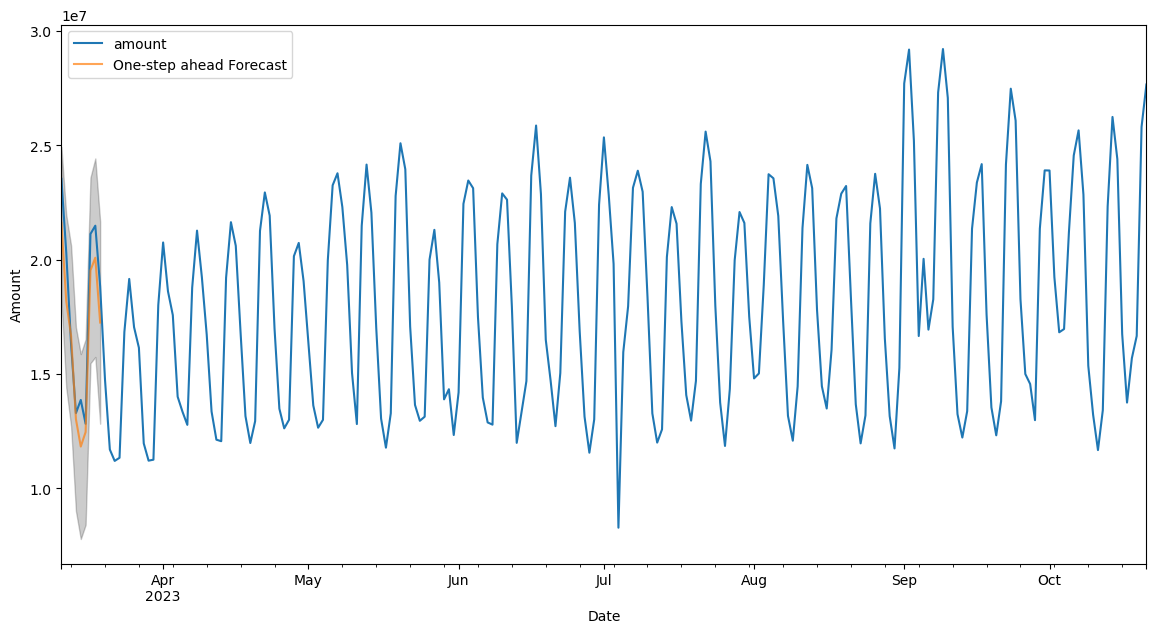

In [163]:
###GENERATE THE CONFIDENCE BANDS OF THE ESTIMATES (LOWER AND UPPER LIMIT) AND PLOT THE PREDICTED VALUE VS. THE ACTUAL VALUE

pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()